# YouTube Trending Video Analysis with SQL

## 1. Setup: Importing Libraries and Mounting Google Drive

In [31]:
# Importing necessary libraries
import pandas as pd
import json
import sqlite3

# Mounting Google Drive to access our files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Load and Prepare DataFrames

In [32]:
# --- Defining file paths ---
# Updating this path if your folder structure is different
base_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/'
videos_csv_path = base_path + 'USvideos.csv'
categories_json_path = base_path + 'US_category_id.json'

# --- Loading the videos CSV file ---
df_videos = pd.read_csv(videos_csv_path)

# --- Reading and parsing the JSON category file ---
with open(categories_json_path, 'r') as f:
    data = json.load(f)

df_categories = pd.json_normalize(data['items'])

# Selecting and renaming the columns for clarity
df_categories = df_categories[['id', 'snippet.title']]
df_categories.rename(columns={'snippet.title': 'category_name'}, inplace=True)

# Converting the 'id' column to an integer to ensure the JOIN will work
df_categories['id'] = df_categories['id'].astype(int)

print("✅ DataFrames for videos and categories created successfully.")
print("Categories DataFrame head:")
display(df_categories.head())

✅ DataFrames for videos and categories created successfully.
Categories DataFrame head:


,id,category_name
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


## 3. Creating SQLite Database and Load Tables

In [33]:
# Creating a connection to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Writing the DataFrames to the database as SQL tables
df_videos.to_sql('USvideos', conn, if_exists='replace', index=False)
df_categories.to_sql('UScategories', conn, if_exists='replace', index=False)

print("SQLite database created and tables 'USvideos' and 'UScategories' are loaded.")

SQLite database created and tables 'USvideos' and 'UScategories' are loaded.


## 4. Analysis & Visualization
* In this section, we will query the database to answer our business questions.

In [37]:
# Importing the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Setting a style for the plots
sns.set_style('whitegrid')

In [54]:
# Step 1: Install the necessary fonts
!sudo apt-get install -y fonts-nanum

# Step 2: Directly register the font with matplotlib
import matplotlib.font_manager as fm

# Define the path to the Nanum font
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# Add the font to matplotlib's font manager
# This makes the font available for use in plots
fm.fontManager.addfont(font_path)

# Set the newly added font as the default for all plots
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### Question 1: Which video categories are the most popular?

To find this, we will join our two tables, group by the category name, and count the number of videos in each category.

In [34]:
# --- Query 1: Top 10 Most Popular Categories ---

# Defining the SQL query as a multi-line string
query_top_categories = """
SELECT
    cat.category_name,
    COUNT(*) AS video_count
FROM
    USvideos AS vid
JOIN
    UScategories AS cat ON vid.category_id = cat.id
GROUP BY
    cat.category_name
ORDER BY
    video_count DESC
LIMIT 10;
"""

top_categories_df = pd.read_sql_query(query_top_categories, conn)

print("Top 10 Most Popular Video Categories:")
display(top_categories_df)

Top 10 Most Popular Video Categories:


,category_name,video_count
0,Entertainment,9964
1,Music,6472
2,Howto & Style,4146
3,Comedy,3457
4,People & Blogs,3210
5,News & Politics,2487
6,Science & Technology,2401
7,Film & Animation,2345
8,Sports,2174
9,Education,1656


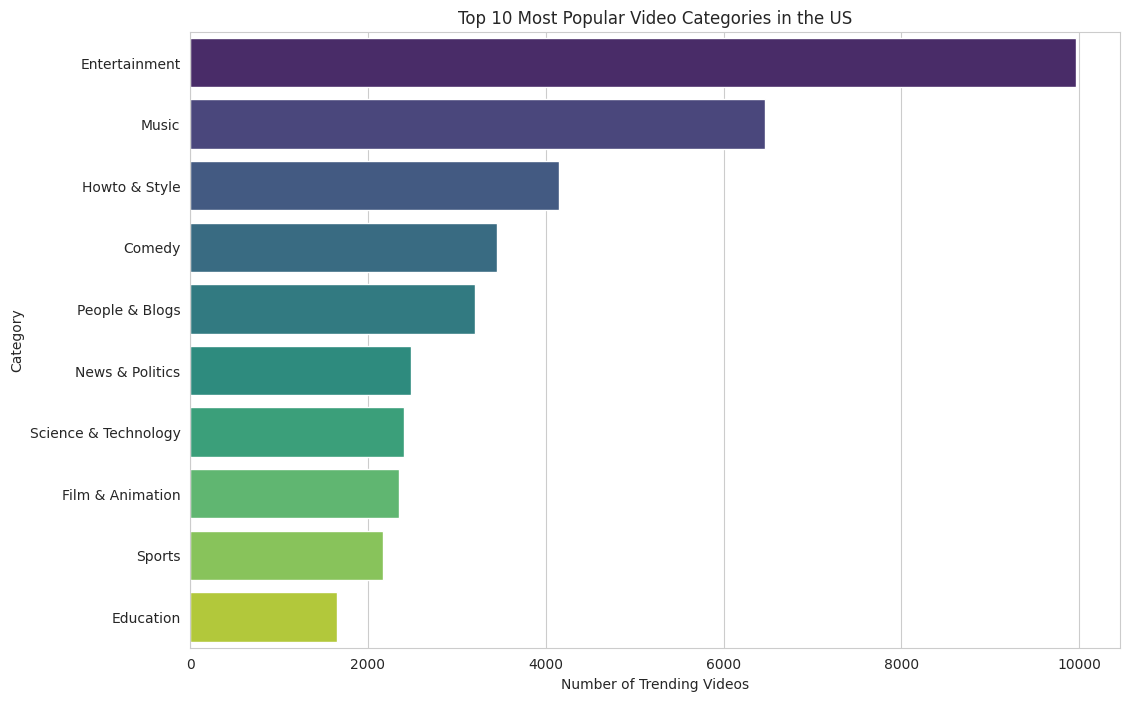

In [45]:
# --- Visualization for Query 1 ---
plt.figure(figsize=(12, 8))

sns.barplot(
    x='video_count',
    y='category_name',
    data=top_categories_df,
    palette='viridis',
    hue='category_name',
    legend=False
)

plt.title('Top 10 Most Popular Video Categories in the US')
plt.xlabel('Number of Trending Videos')
plt.ylabel('Category')
plt.gca()
plt.show()

### Question 2: Which videos are the most loved (highest like-to-view ratio)?

* Here, we will calculate a new metric, the like-to-view ratio, for each video. We'll filter for videos with over 1 million views to ensure we are looking at a significant sample size.

In [35]:
# --- Query 2: Top 10 Most Loved Videos (Like-to-View Ratio) ---

query_like_ratio = """
SELECT
    channel_title,
    title,
    views,
    likes,
    (CAST(likes AS REAL) / views) * 100 AS like_ratio_percent
FROM
    USvideos
WHERE
    views > 1000000 -- Only consider videos with a substantial number of views
ORDER BY
    like_ratio_percent DESC
LIMIT 10;
"""

like_ratio_df = pd.read_sql_query(query_like_ratio, conn)

print("Top 10 Most Loved Videos (by Like-to-View Ratio):")
display(like_ratio_df)

Top 10 Most Loved Videos (by Like-to-View Ratio):


,channel_title,title,views,likes,like_ratio_percent
0,ibighit,j-hope 'Airplane' MV,5275672,1401915,26.573202
1,ibighit,BTS (방탄소년단) 'FAKE LOVE' Official MV (Extended ...,5884233,1437859,24.435793
2,ibighit,j-hope 'Airplane' MV,6870836,1566591,22.800588
3,ibighit,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...,3483755,789750,22.669505
4,Desimpedidos,"CRISTIANO RONALDO E FRED, O GRANDE ENCONTRO",3990953,889008,22.275582
5,ibighit,j-hope 'Airplane' MV,7610082,1621717,21.310112
6,ShawnMendesVEVO,Shawn Mendes - In My Blood,2822006,598247,21.199353
7,ibighit,BTS (방탄소년단) 'Euphoria : Theme of LOVE YOURSELF...,7518332,1572997,20.922154
8,BANGTANTV,Official Trailer | BTS: Burn The Stage,1801695,369820,20.526227
9,SMTOWN,EXO 'Electric Kiss' MV -Short Ver.-,1840613,372289,20.226359


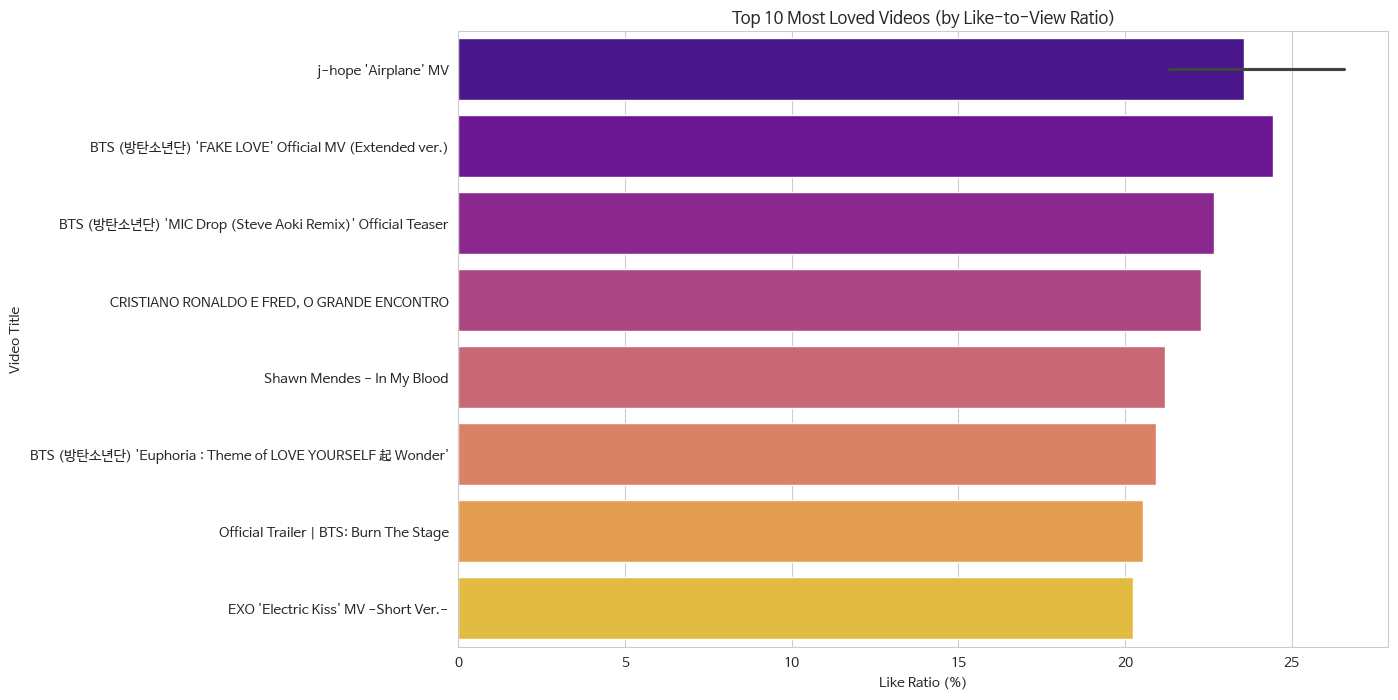

In [57]:
# --- Visualization for Query 2 ---
plt.figure(figsize=(12, 8))

sns.barplot(
    x='like_ratio_percent',
    y='title',
    data=like_ratio_df,
    palette='plasma',
    hue='title',
    legend=False,
)

plt.title('Top 10 Most Loved Videos (by Like-to-View Ratio)')
plt.xlabel('Like Ratio (%)')
plt.ylabel('Video Title')
plt.gca()
plt.show()

### Question 3: Which channels get the most likes on average?

* This query will help us identify channels that consistently produce highly engaging content. We'll group by the channel title and calculate the average number of likes for each.

In [36]:
# --- Query 3: Top 10 Channels by Average Likes ---

query_avg_likes = """
SELECT
    channel_title,
    -- Calculate the average of the 'likes' column and round it to a whole number
    ROUND(AVG(likes)) AS average_likes
FROM
    USvideos
GROUP BY
    channel_title
ORDER BY
    average_likes DESC
LIMIT 10;
"""

avg_likes_df = pd.read_sql_query(query_avg_likes, conn)

print("Top 10 Channels by Average Likes:")
display(avg_likes_df)

Top 10 Channels by Average Likes:


,channel_title,average_likes
0,ChildishGambinoVEVO,3868033.0
1,ibighit,2490589.0
2,David Dobrik,1837513.0
3,LuisFonsiVEVO,1667143.0
4,Logan Paul Vlogs,1314387.0
5,ArianaGrandeVevo,1213278.0
6,YouTube Spotlight,1120740.0
7,Desimpedidos,1017472.0
8,BeckyGVEVO,959264.0
9,TheWeekndVEVO,894567.0


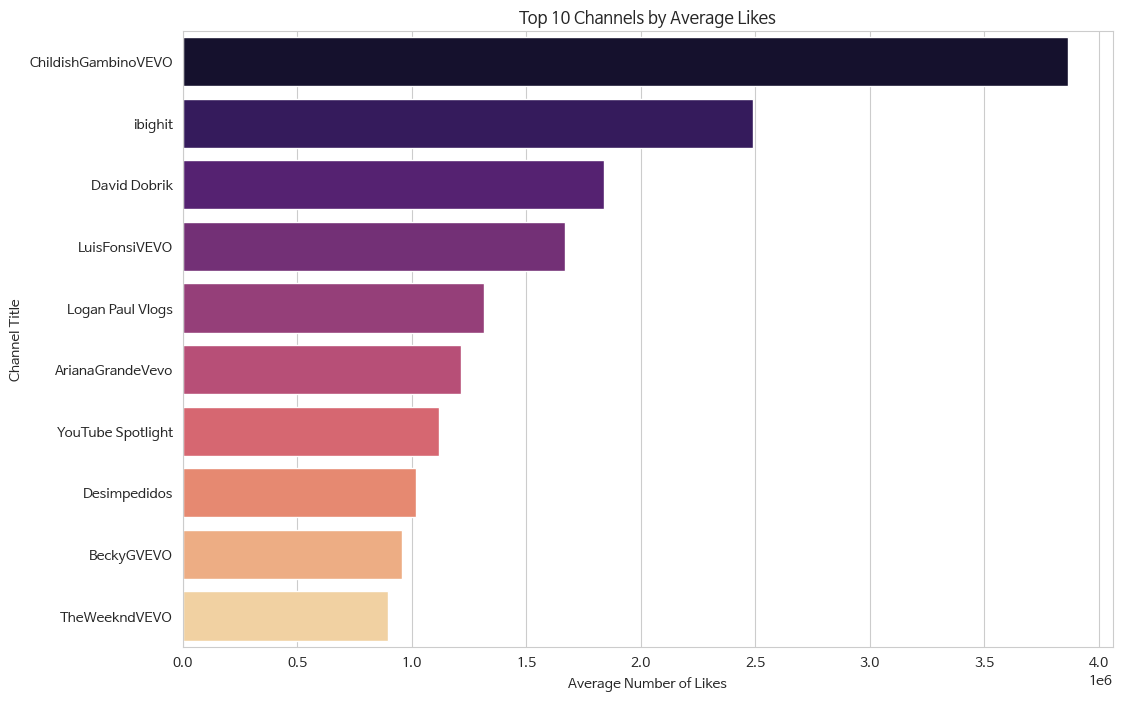

In [60]:
# --- Visualization for Query 3 ---
plt.figure(figsize=(12, 8))

sns.barplot(
    x='average_likes',
    y='channel_title',
    data=avg_likes_df,
    palette='magma',
    hue='channel_title',
    legend=False
)

plt.title('Top 10 Channels by Average Likes')
plt.xlabel('Average Number of Likes')
plt.ylabel('Channel Title')
plt.gca()
plt.show()